# Price prediction using LSTM

Using an LSTM to predict price changes in the value of Bitcoin and gold.  Then, using predicted values to decide what changes to make to our portfolio at each day.

## Bitcoin price prediction model

Inspired by *https://www.kaggle.com/code/meetnagadia/bitcoin-price-prediction-using-lstm/notebook*

### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

# Evaluation libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# Model libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM


# Plotting libraries
import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

### Load dataset

In [2]:
bc_df = pd.read_csv("BCHAIN-MKPRU.csv")
print(f"Total number of days: {bc_df.shape[0]}")
print(f"Number of columns: {bc_df.shape[1]}")
print(f"Null values: {bc_df.isnull().values.sum()}")

# Make sure date column has datetime objects
bc_df['Date'] = pd.to_datetime(bc_df['Date'])
bc_df.head()

Total number of days: 1826
Number of columns: 2
Null values: 0


C:\Users\n8moo\AppData\Local\Temp\ipykernel_18572\3529312939.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bc_df['Date'] = pd.to_datetime(bc_df['Date'])


,Date,Value
0,2016-09-11,621.65
1,2016-09-12,609.67
2,2016-09-13,610.92
3,2016-09-14,608.82
4,2016-09-15,610.38


In [3]:
# Start and end dates
start_date = bc_df.iloc[0]['Date']
end_date = bc_df.iloc[-1]['Date']
print(start_date, end_date)

2016-09-11 00:00:00 2021-09-10 00:00:00


In [13]:
# Get first year of values
first_two_years = bc_df[bc_df['Date'] < '2018-09-11']

first_year = first_two_years[first_two_years['Date'] < '2017-09-11']
print(f"Total data for prediction: {first_year.shape[0]}")

# Get second year of values
second_year = first_two_years[first_two_years['Date'] > '2017-09-10']
print(second_year.shape[0])

# Plot first year of data
fig = px.line(first_year, x=first_year.Date, y=first_year.Value, labels={'date':'Date','value':'Value'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Bitcoin close price', 
                  plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Total data for prediction: 365
365


#### Normalize data

In [ ]:
# Normalize data

# Delete date column because it can't be normalized
del first_year['Date']
del second_year['Date']

scaler = MinMaxScaler(feature_range=(0,1))
first_year = scaler.fit_transform(np.array(first_year).reshape(-1,1))
second_year = scaler.fit_transform(np.array(second_year).reshape(-1,1))
print(first_year.shape, second_year.shape)

(365, 1) (365, 1)


#### Split into training/test data

In [15]:
training_size = len(first_year)  # Training data is first year
test_size = len(second_year)     # Test data is second year
train_data, test_data = first_year, second_year

print(train_data.shape, test_data.shape)

(365, 1) (365, 1)


#### Converting data into correct format for LSTM

In [8]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [80]:
# I guess we need to do this
time_step = 1
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", x_test.shape)
print("y_test", y_test.shape)

X_train:  (363, 1)
y_train:  (363,)
X_test:  (363, 1)
y_test (363,)


In [81]:
# reshape input to be [samples, time steps, features] which is required for LSTM
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)

print("X_train: ", x_train.shape)
print("X_test: ", x_test.shape)

X_train:  (363, 1, 1)
X_test:  (363, 1, 1)


#### Training the model!!!!!!!!!!!!

In [82]:
bc_model = Sequential()
bc_model.add(LSTM(10, activation="relu"))
bc_model.add(Dense(1))
bc_model.compile(loss="mean_squared_error", optimizer="adam")

In [83]:
history = bc_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=200, batch_size=32, verbose=1)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1108 - val_loss: 0.1299
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1097 - val_loss: 0.1183
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0864 - val_loss: 0.1078
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0862 - val_loss: 0.0978
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0714 - val_loss: 0.0889
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0768 - val_loss: 0.0804
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0658 - val_loss: 0.0729
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0676 - val_loss: 0.0660
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0579 - val_loss: 0.0598
Epoch 10/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0617 - val_loss: 0.0537
Epoch 11/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0584 - val_loss: 0.0483
Epoch 12/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

#### Plot loss and validation loss (how did the model do overtime)

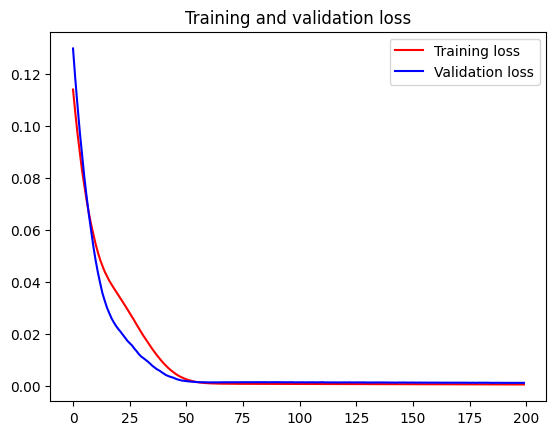

<Figure size 640x480 with 0 Axes>

In [84]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

#### Test predictions and compute performance metrics

In [85]:
train_predict=bc_model.predict(x_train)
test_predict=bc_model.predict(x_test)
train_predict.shape, test_predict.shape

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


((363, 1), (363, 1))

In [86]:
# Model evaluation

# Reverse the normalization
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

# Evaluation metrics


# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  416.0256541906829
Train data MSE:  173077.3449447857
Train data MAE:  275.86692581258694
-------------------------------------------------------------------------------------
Test data RMSE:  584.5877801333347
Test data MSE:  341742.8726812201
Test data MAE:  394.71386026683024


In [93]:
def unshift_data(predicted_values, original_length, time_step):
    """
    Reconstruct the original time series from shifted data.

    Parameters:
        predicted_values (numpy array): The predicted Y values.
        original_length (int): Length of the original dataset.
        time_step (int): The time step used for shifting.

    Returns:
        numpy array: The reconstructed series with NaN for unfilled positions.
    """
    reconstructed = np.full(original_length, np.nan)
    predicted_values = predicted_values.flatten()  # Ensure 1D array
    # print(len(predicted_values), predicted_values.shape)
    reconstructed[time_step : time_step + len(predicted_values)] = predicted_values
    return reconstructed

#### Plot predictions

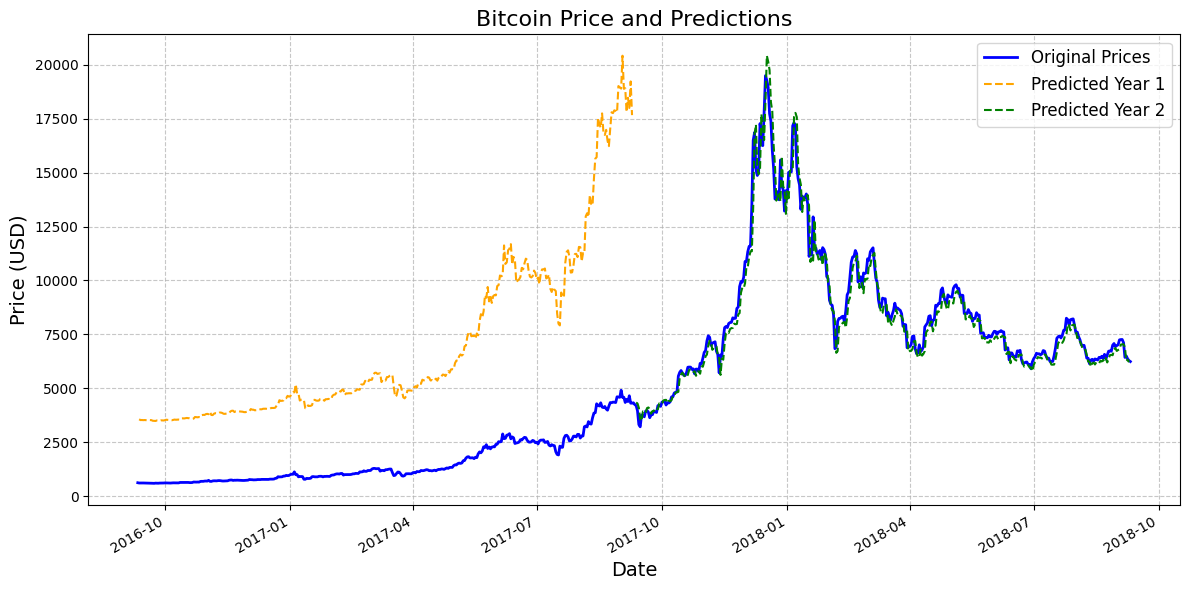

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: Replace these with your actual data
# Original price data for two years (assumed daily values for simplicity)
dates = np.arange("2016-09-11", "2018-09-11", dtype="datetime64[D]")

# Predicted values for Year 1 and Year 2
predicted_year_1 = unshift_data(train_predict, 365, 1)  # Replace with actual predictions for Year 1
predicted_year_2 = unshift_data(test_predict, 365, 1)  # Replace with actual predictions for Year 2

# Dates for Year 1 and Year 2
dates_year_1 = dates[:365]
dates_year_2 = dates[365:730]  # Adjust index range based on data

# Plot the original data
plt.figure(figsize=(12, 6))
plt.plot(dates, first_two_years['Value'], label="Original Prices", color="blue", linewidth=2)

# Overlay the predictions
plt.plot(dates_year_1, predicted_year_1, label="Predicted Year 1", color="orange", linestyle="--")
plt.plot(dates_year_2, predicted_year_2, label="Predicted Year 2", color="green", linestyle="--")

# Customize the plot
plt.title("Bitcoin Price and Predictions", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Price (USD)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

# Format the x-axis for better readability
plt.gcf().autofmt_xdate()

# Show the plot
plt.tight_layout()
plt.show()


Not sure what's happening with year 1 up there but I think I'm doing something wrong with the data.  It does pretty good for the second year.

## Testing retrieving predictions for a given day

In [128]:
max_days = 10

# Data to start off with
data = x_test  # Shape: (363, 1, 1)

for day in range(max_days):
    # Reshape data to ensure compatibility for prediction
    #input_data = data.reshape(1, -1, 1)  # Shape: (1, time_steps, features)

    # Predict the next price
    predicted_price = bc_model.predict(data)  # Output: (1, 1)
    print(predicted_price.shape)
    actual_predicted_price = scaler.inverse_transform(predicted_price)[0,0]
    print(f"Predicted price for day {day}: {actual_predicted_price}")

    # Prepare the predicted price to match the feature shape
    predicted_step = np.array([[[predicted_price[0, 0]]]])  # Shape: (1, 1, 1)

    # Append the predicted price and maintain the original shape
    data = np.vstack([data, predicted_step])  # Add the new step, Shape: (samples+1, 1, 1)
    data = data[1:]  # Keep the last 363 steps, MUST BE THE SAME SHAPE AS x_train TO GET PROPER VALUES

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
(363, 1)
Predicted price for day 0: 4341.14404296875
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
(363, 1)
Predicted price for day 1: 4299.04052734375
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(363, 1)
Predicted price for day 2: 4098.19970703125
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(363, 1)
Predicted price for day 3: 3563.62109375
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
(363, 1)
Predicted price for day 4: 3486.709716796875
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
(363, 1)
Predicted price for day 5: 3932.218017578125
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
(363, 1)
Predicted price for day 6: 3917.523681640625
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
(363, 1)
Predicted price for day 7: 3861.11474609375
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
(363, 1)
Predicted price for day 8: 4083.154541015625
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(363, 1)
Predicted price for day 9: 4111.93212890625


## Decision model using Bitcoin price predictions

In [ ]:
max_days = 365 * 5

# 

# Data to start with (1 value, start of year 2)
bc_data = []
bc_data.append(x_test[0])
prev_price = scaler.inverse_transform(bc_data[0])[0,0]
print(prev_price)

#for day in range(max_days):



4248.090017
